# Flow Matching for Allen-Cahn Dynamics

This notebook tries a flow matching approach to learn the temporal evolution of Allen-Cahn PDE solutions by training a neural network to predict velocity fields along linear interpolation paths between paired initial and final states.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

### Step 1: Defining the Flow Matching Model Architecture

### 1.1. A little theory:

A **flow model** learns a **velocity field** `v(x, t)` that predicts how the system state evolves over time.

**Governing Equation:** `dx/dt = v(x, t)`

where:
- `x ∈ ℝ^N` is the **state vector** (the Allen-Cahn field discretized at N=200 spatial points)
- `t ∈ [0,1]` is **normalized time** 
- `v(x,t) ∈ ℝ^N` is the **velocity field** (change in state per unit time)

**Model Input:** Current state `x` and time `t`  
**Model Output:** Velocity vector `v(x,t)`

The neural network only approximates the velocity field `v(x,t)`. 
To evolve from an initial state `x_0` to a final state `x_1`, we integrate the velocity field along the trajectory defined by the differential equation `dx/dt = v(x,t)`.


### 1.2. Architecture Components

**1. Input Processing**
- **Input concatenation**: `[state, time]` → `[200 + 1 = 201 dimensions]`
  - State vector: 200 spatial points from the Allen-Cahn field
  - Time scalar: 1 value representing current time `t`
  
- **First linear layer**: 201 → 512 dimensions
  - Expands the input into a high-dimensional representation space
  - 512 hidden units provide sufficient capacity to learn complex nonlinear mappings
    
- **LayerNorm + SiLU**: Stabilizes training and adds smooth non-linearity

**2. Deep Feature Extraction**
- **6 hidden layers**: Each with 512 → 512 transformation
- **Each layer contains**:
  - Linear transformation (512 → 512)
  - LayerNorm (stabilizes gradients)
  - SiLU activation (smooth non-linearity)
  - Dropout 10% (prevents overfitting by randomly zeroing activations)

**3. Time Embedding Network**
- **Motivation**: Time `t` is a single scalar, but its influence on dynamics is complex
- **Architecture**: Separate 2-layer MLP (1 → 64 → 64)
  - First layer: 1 → 64 (expands time into rich representation)
  - Second layer: 64 → 64 (refines temporal features)
  - SiLU activation between layers
  
- **Why 64 dimensions?**
  - Provides sufficient complexity to encode time-dependent behavior
  - Smaller than state embedding (512) since time has less intrinsic complexity
  - Similar to sinusoidal positional encoding in Transformers
  
- **How it works**:
  - Raw time `t=0.3` → 64-dim vector capturing "what phase of evolution"
  - Allows model to distinguish: early dynamics (t≈0) vs late dynamics (t≈1)

**4. Output Layer**
- **Final projection**: 512 → 200 dimensions
  - Maps back to state space (200 spatial points)
  - Each output value represents velocity at one spatial location

In [2]:
# --- Flow Model ---
class FlowModel(nn.Module):
    def __init__(self, dim, hidden_size=512, num_layers=6):
        super().__init__()
        
        # Input: state (dim) + time (1)
        layers = []
        layers.append(nn.Linear(dim + 1, hidden_size))
        layers.append(nn.LayerNorm(hidden_size))  # Add normalization
        layers.append(nn.SiLU())  # Better activation than ReLU
        
        # Hidden layers with residual connections
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.LayerNorm(hidden_size))
            layers.append(nn.SiLU())
            layers.append(nn.Dropout(0.1))  # Regularization
        
        layers.append(nn.Linear(hidden_size, dim))
        
        self.net = nn.Sequential(*layers)
        
        # Time embedding (positional encoding)
        self.time_embed = nn.Sequential(
            nn.Linear(1, 64),
            nn.SiLU(),
            nn.Linear(64, 64)
        )
    
    def forward(self, x, t):
        # Enhanced time encoding
        t_embed = self.time_embed(t)
        
        # Expand time embedding to match batch
        t_expanded = t_embed.expand(x.shape[0], -1)
        
        # Concatenate with state
        x_t = torch.cat([x, t], dim=-1)
        
        return self.net(x_t)


### Step 2: Generating Training Data

We generate 1000 training pairs `(x_0, x_1)` by numerically solving the Allen-Cahn PDE using finite differences to evolve initial conditions forward in time.

#### Key Parameters:

- **Spatial discretization**: 200 grid points on domain `[-1, 1]`
- **Evolution time**: `T ∈ [0.01, 0.1]` seconds (varied per sample)
- **Initial conditions**: Four types (sine waves, cosine waves, Gaussian bumps, random noise)

#### Dataset Structure:

Each training sample contains:
- `x_0`: Initial Allen-Cahn field (200 spatial points)
- `x_1`: Evolved field after time `T`
- `T`: Evolution duration

This diversity ensures the model learns general Allen-Cahn dynamics rather than memorizing specific patterns.

In [3]:

# --- Part 2: Generate DIVERSE Training Dataset ---
print("=" * 60)
print("PART 2: Generating Training Dataset")
print("=" * 60)

eps = 0.1
Nx = 200
x_domain_np = np.linspace(-1, 1, Nx)
dx = x_domain_np[1] - x_domain_np[0]
dt_fd = 1e-5

def allen_cahn_fd_step_np(u, eps, dt, dx):
    """Finite difference step for Allen-Cahn equation"""
    u_xx = (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2
    # Neumann boundary conditions
    u_xx[0] = (u[1] - 2 * u[0] + u[1]) / dx**2
    u_xx[-1] = (u[-2] - 2 * u[-1] + u[-2]) / dx**2
    dudt = u_xx + (u - u**3) / eps**2
    return u + dt * dudt

# Generate training data with MULTIPLE evolution times
training_data = []
n_training_samples = 1000  # More samples!

print(f"\nGenerating {n_training_samples} training pairs...")

for sample_idx in tqdm(range(n_training_samples)):
    # Strategy 1: Vary frequency
    frac = np.random.uniform(0.3, 4.0)
    
    # Strategy 2: Random initial condition type
    ic_type = np.random.choice(['sine', 'cosine', 'bumps', 'random'])
    
    if ic_type == 'sine':
        u_0_np = np.sin(frac * np.pi * x_domain_np) * (x_domain_np + 1)**2 * (x_domain_np - 1)**2
    elif ic_type == 'cosine':
        u_0_np = np.cos(frac * np.pi * x_domain_np) * (x_domain_np + 0.5)**2 * (x_domain_np - 0.5)**2
    elif ic_type == 'bumps':
        u_0_np = np.zeros(Nx)
        n_bumps = np.random.randint(1, 4)
        for _ in range(n_bumps):
            center = np.random.uniform(-0.8, 0.8)
            width = np.random.uniform(0.1, 0.4)
            amplitude = np.random.uniform(-0.9, 0.9)
            u_0_np += amplitude * np.exp(-((x_domain_np - center) / width)**2)
    else:  # random
        u_0_np = np.random.uniform(-0.5, 0.5, Nx)
    
    # Add noise
    u_0_np += np.random.normal(0, 0.03, size=u_0_np.shape)
    
    # CRITICAL: we must vary the evolution time!
    T_evolution = np.random.uniform(0.01, 0.1)  # Different durations
    n_steps = int(T_evolution / dt_fd)
    
    # Simulate forward
    u_current_np = u_0_np.copy()
    for _ in range(n_steps):
        u_current_np = allen_cahn_fd_step_np(u_current_np, eps, dt_fd, dx)
    u_1_np = u_current_np
    
    # Store the pair with normalized time
    training_data.append({
        'x_0': torch.tensor(u_0_np, dtype=torch.float32),
        'x_1': torch.tensor(u_1_np, dtype=torch.float32),
        'T': T_evolution  # Store actual evolution time
    })

print(f"  Dataset complete: {len(training_data)} training pairs")
print(f"  Time range: {min(d['T'] for d in training_data):.4f} - {max(d['T'] for d in training_data):.4f} seconds")

# Convert to tensors
x_0_all = torch.stack([d['x_0'] for d in training_data])
x_1_all = torch.stack([d['x_1'] for d in training_data])
T_all = torch.tensor([d['T'] for d in training_data], dtype=torch.float32)


PART 2: Generating Training Dataset

Generating 1000 training pairs...


100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s]

  Dataset complete: 1000 training pairs
  Time range: 0.0101 - 0.0999 seconds


### Step 3: Training the Flow Model

#### Training Configuration

- **Training steps**: 30,000
- **Batch size**: 64
- **Optimizer**: AdamW (learning rate: 2e-4)
- **Loss function**: Mean Squared Error (MSE)

#### Training Process

The main idea is to train the model to predict velocities along straight-line paths between initial and final states.

**Each training step:**

1. **Sample batch**: Select 64 random pairs `(x_0, x_1)` from training data

2. **Random interpolation**:    Pick random time `t ∈ [0,1]` and compute intermediate state:
                                
`x_t = (1-t) · x_0 + t · x_1`


3. **Compute target**:  The velocity along this straight path is simply:

`v_target = x_1 - x_0`

4. **Model prediction**: Ask the model to predict velocity at `(x_t, t)`

5. **Compute loss**: MSE between predicted and target velocity

6. **Update weights**: Backpropagation with gradient clipping

The model learns to predict velocities that, when integrated over time, transform `x_0` into `x_1`.

In [4]:
# --- Part 3: Training ---
print("\n" + "=" * 60)
print("PART 3: Training the Flow Model")
print("=" * 60)

flow_model = FlowModel(dim=Nx, hidden_size=512, num_layers=6)
optimizer = torch.optim.AdamW(flow_model.parameters(), lr=2e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30000, eta_min=1e-6)
loss_fn = nn.MSELoss()

training_steps = 30000
batch_size = 64
best_loss = float('inf')

print(f"\nTraining configuration:")
print(f"  Steps: {training_steps}")
print(f"  Batch size: {batch_size}")
print(f"  Initial LR: {optimizer.param_groups[0]['lr']:.2e}")
print(f"  Model parameters: {sum(p.numel() for p in flow_model.parameters()):,}")

print("\nTraining progress:")
for step in range(training_steps):
    # Sample random batch
    indices = torch.randint(0, len(training_data), (batch_size,))
    x_0_batch = x_0_all[indices]
    x_1_batch = x_1_all[indices]
    
    # Random interpolation parameter
    t = torch.rand(batch_size, 1)
    
    # Linear interpolation path
    x_t = (1 - t) * x_0_batch + t * x_1_batch
    
    # Target: constant velocity along straight path
    target_velocity = x_1_batch - x_0_batch
    
    # Model prediction
    predicted_velocity = flow_model(x_t, t)
    
    # Loss
    loss = loss_fn(predicted_velocity, target_velocity)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(flow_model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    
    # Track best model
    if loss.item() < best_loss:
        best_loss = loss.item()
    
    # Logging
    if step % 3000 == 0 or step == training_steps - 1:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"  Step {step+1:5d}/{training_steps} | Loss: {loss.item():.6f} | Best: {best_loss:.6f} | LR: {current_lr:.2e}")

print("\nTraining Complete!")



PART 3: Training the Flow Model

Training configuration:
  Steps: 30000
  Batch size: 64
  Initial LR: 2.00e-04
  Model parameters: 1,529,736

Training progress:
  Step     1/30000 | Loss: 0.643313 | Best: 0.643313 | LR: 2.00e-04
  Step  3001/30000 | Loss: 0.033621 | Best: 0.023821 | LR: 1.95e-04
  Step  6001/30000 | Loss: 0.027246 | Best: 0.017549 | LR: 1.81e-04
  Step  9001/30000 | Loss: 0.019793 | Best: 0.012301 | LR: 1.59e-04
  Step 12001/30000 | Loss: 0.013986 | Best: 0.009358 | LR: 1.31e-04
  Step 15001/30000 | Loss: 0.010302 | Best: 0.009054 | LR: 1.00e-04
  Step 18001/30000 | Loss: 0.010474 | Best: 0.007327 | LR: 6.97e-05
  Step 21001/30000 | Loss: 0.008555 | Best: 0.006755 | LR: 4.20e-05
  Step 24001/30000 | Loss: 0.008317 | Best: 0.006271 | LR: 2.00e-05
  Step 27001/30000 | Loss: 0.009115 | Best: 0.006049 | LR: 5.87e-06
  Step 30000/30000 | Loss: 0.007395 | Best: 0.005955 | LR: 1.00e-06

Training Complete!


### Step 4: Testing with Different Integration Methods

We test the trained model using three different approaches to evolve from initial state `x_0` to final state `x_1`:

### Integration Methods

**Single-step prediction** asks the model once for the velocity at `t=1` and jumps directly: `x_1 = x_0 + v(x_0, t=1)`. This is fast but assumes the learned velocity field is accurate enough for one large step. In our case it will be very bad and thats ok.

**Multi-step integration** (10 or 100 steps) breaks the journey into smaller increments, repeatedly querying the model at intermediate times: `x_{i+1} = x_i + v(x_i, t_i)/n_steps`.

In [5]:
# --- Part 4: Testing ---
print("\n" + "=" * 60)
print("PART 4: Testing Generalization")
print("=" * 60)

# Test on thre unseen cases
test_cases = [
    {"name": "Smooth Cosine", "func": lambda x: 0.6 * np.cos(1.5 * np.pi * x) * (x + 0.5)**2 * (x - 0.5)**2, "T": 0.05},
    {"name": "Sharp Sine", "func": lambda x: 0.8 * np.sin(2.5 * np.pi * x) * (x + 1)**2 * (x - 1)**2, "T": 0.05},
    {"name": "Double Bump", "func": lambda x: 0.5 * (np.exp(-((x+0.4)/0.15)**2) + np.exp(-((x-0.4)/0.15)**2)), "T": 0.05},
]

flow_model.eval()

for test_idx, test_case in enumerate(test_cases):
    print(f"\nTest Case {test_idx + 1}: {test_case['name']}")
    print("-" * 40)
    
    # Generate test initial condition
    test_u_0_np = test_case['func'](x_domain_np)
    T_test = test_case['T']
    n_steps_test = int(T_test / dt_fd)
    
    # Ground truth (expensive simulation)
    test_u_current_np = test_u_0_np.copy()
    for _ in range(n_steps_test):
        test_u_current_np = allen_cahn_fd_step_np(test_u_current_np, eps, dt_fd, dx)
    test_u_1_true = test_u_current_np
    
    # Convert to tensors
    test_x_0 = torch.tensor(test_u_0_np, dtype=torch.float32).unsqueeze(0)
    test_x_1_true = torch.tensor(test_u_1_true, dtype=torch.float32).unsqueeze(0)
    
    with torch.no_grad():
        # Method 1: Single-step prediction
        t_final = torch.ones(1, 1)
        velocity_single = flow_model(test_x_0, t_final)
        test_x_1_single = test_x_0 + velocity_single
        
        # Method 2: Multi-step integration (10 steps)
        n_steps_10 = 10
        x_current = test_x_0.clone()
        for i in range(n_steps_10):
            t_step = torch.tensor([[i / n_steps_10]], dtype=torch.float32)
            velocity = flow_model(x_current, t_step)
            x_current = x_current + velocity / n_steps_10
        test_x_1_multi10 = x_current
        
        # Method 3: Multi-step integration (100 steps)
        n_steps_100 = 100
        x_current = test_x_0.clone()
        for i in range(n_steps_100):
            t_step = torch.tensor([[i / n_steps_100]], dtype=torch.float32)
            velocity = flow_model(x_current, t_step)
            x_current = x_current + velocity / n_steps_100
        test_x_1_multi100 = x_current
    
    # Calculate errors
    error_single = torch.mean((test_x_1_single - test_x_1_true)**2).item()
    error_multi10 = torch.mean((test_x_1_multi10 - test_x_1_true)**2).item()
    error_multi100 = torch.mean((test_x_1_multi100 - test_x_1_true)**2).item()
    
    print(f"  MSE (single-step):   {error_single:.6f}")
    print(f"  MSE (10-step):       {error_multi10:.6f}")
    print(f"  MSE (100-step):      {error_multi100:.6f}")
    
    # Improvement metrics
    improvement_10 = (error_single - error_multi10) / error_single * 100
    improvement_100 = (error_single - error_multi100) / error_single * 100
    print(f"  Improvement (10-step):  {improvement_10:+.1f}%")
    print(f"  Improvement (100-step): {improvement_100:+.1f}%")




PART 4: Testing Generalization

Test Case 1: Smooth Cosine
----------------------------------------
  MSE (single-step):   0.530207
  MSE (10-step):       0.042001
  MSE (100-step):      0.035413
  Improvement (10-step):  +92.1%
  Improvement (100-step): +93.3%

Test Case 2: Sharp Sine
----------------------------------------
  MSE (single-step):   0.303151
  MSE (10-step):       0.029331
  MSE (100-step):      0.021238
  Improvement (10-step):  +90.3%
  Improvement (100-step): +93.0%

Test Case 3: Double Bump
----------------------------------------
  MSE (single-step):   0.665987
  MSE (10-step):       0.031086
  MSE (100-step):      0.024876
  Improvement (10-step):  +95.3%
  Improvement (100-step): +96.3%



PART 4: Detailed Visualization


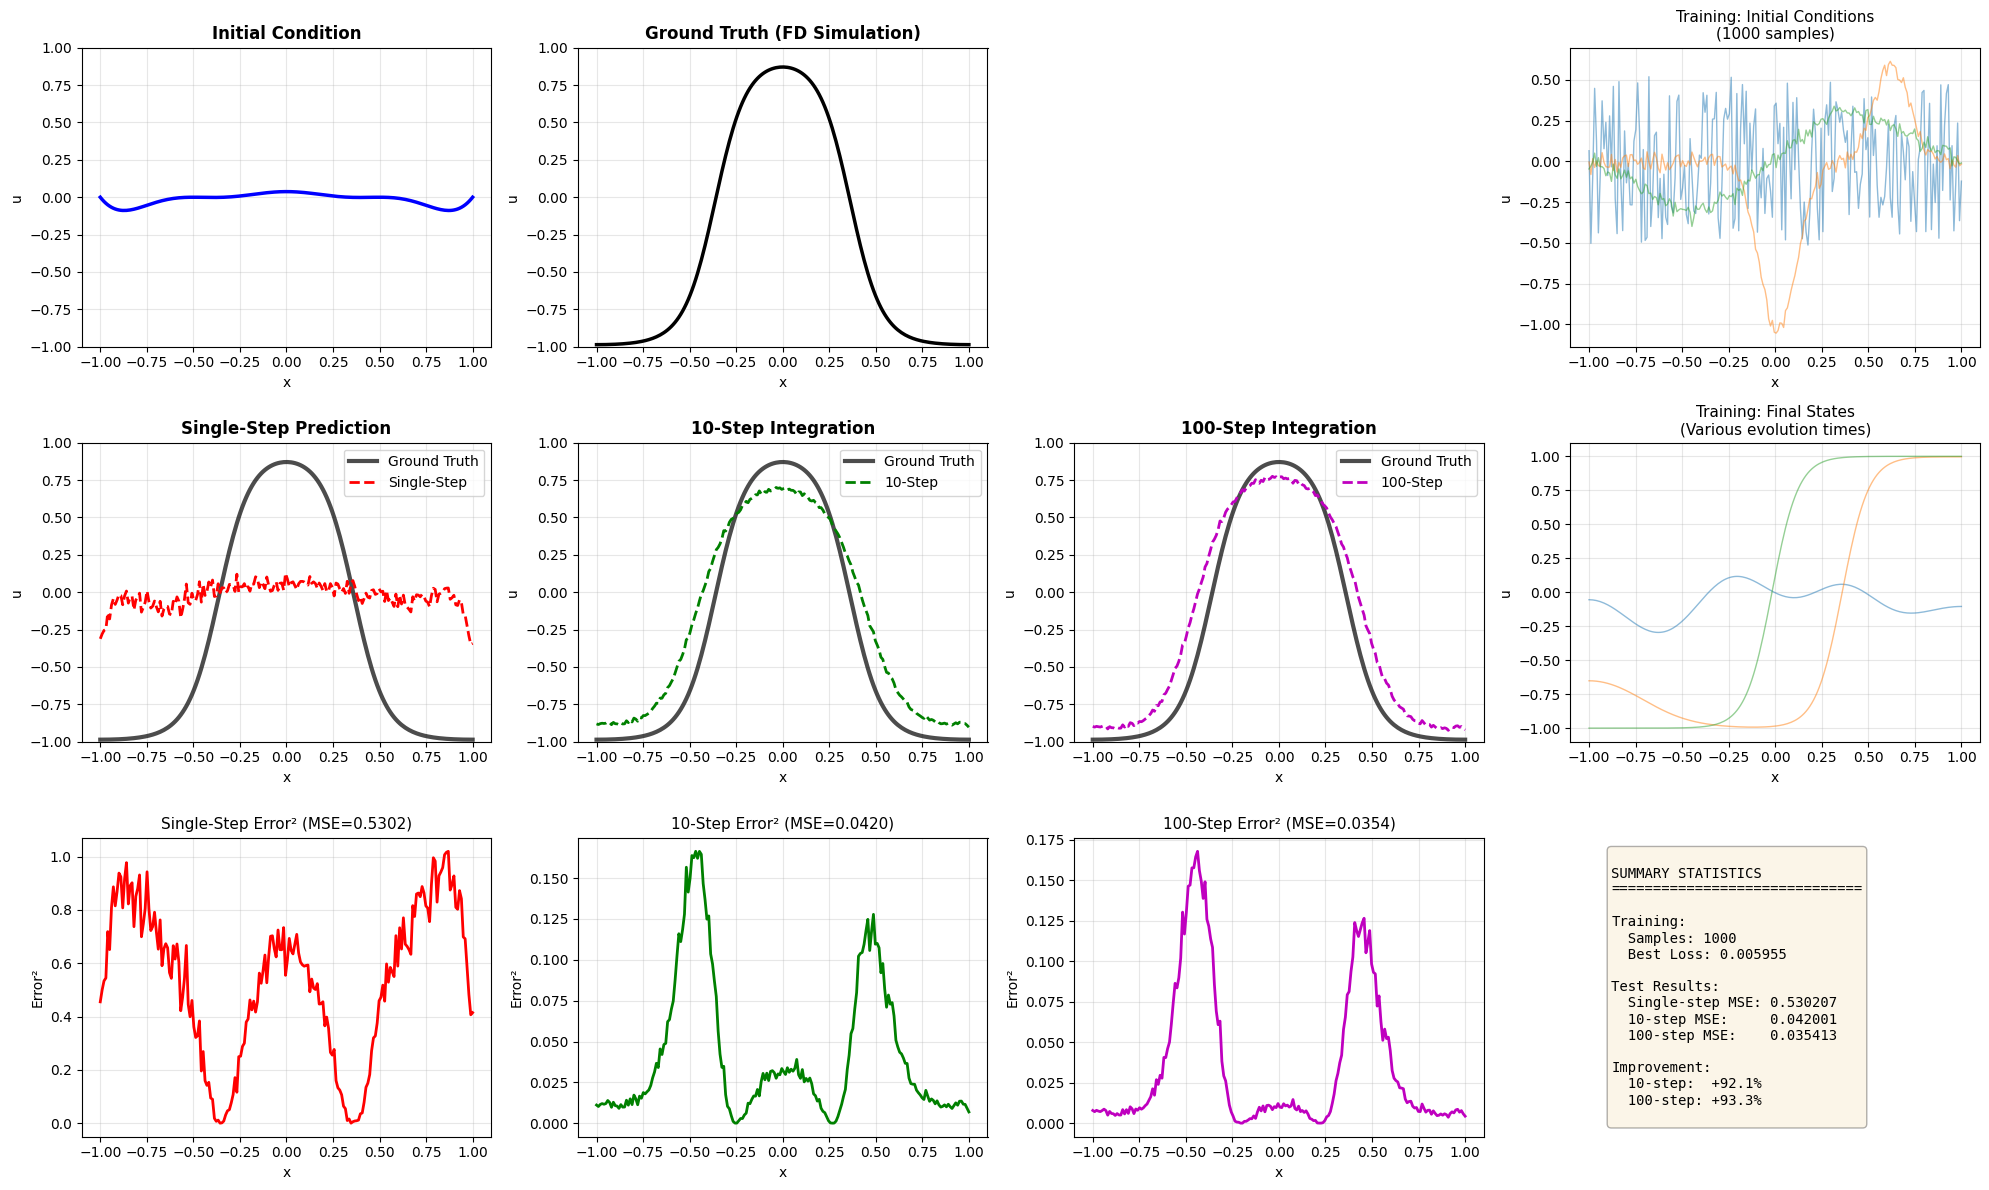


CONCLUSION

Flow Matching Performance on Allen-Cahn:
  Training Loss: 0.005955
  Test MSE (single-step): 0.530207
  Test MSE (100-step):    0.035413


In [6]:
# --- Part 4: Visualization ---
print("\n" + "=" * 60)
print("PART 4: Detailed Visualization")
print("=" * 60)

# Focus on first test case for detailed plots
test_case = test_cases[0]
test_u_0_np = test_case['func'](x_domain_np)
T_test = test_case['T']
n_steps_test = int(T_test / dt_fd)

# Ground truth
test_u_1_true_np = test_u_0_np.copy()
for _ in range(n_steps_test):
    test_u_1_true_np = allen_cahn_fd_step_np(test_u_1_true_np, eps, dt_fd, dx)

test_x_0 = torch.tensor(test_u_0_np, dtype=torch.float32).unsqueeze(0)
test_x_1_true = torch.tensor(test_u_1_true_np, dtype=torch.float32).unsqueeze(0)

flow_model.eval()
with torch.no_grad():
    # All three methods
    t_final = torch.ones(1, 1)
    velocity_single = flow_model(test_x_0, t_final)
    test_x_1_single = test_x_0 + velocity_single
    
    n_steps_10 = 10
    x_current = test_x_0.clone()
    for i in range(n_steps_10):
        t_step = torch.tensor([[i / n_steps_10]], dtype=torch.float32)
        velocity = flow_model(x_current, t_step)
        x_current = x_current + velocity / n_steps_10
    test_x_1_multi10 = x_current
    
    n_steps_100 = 100
    x_current = test_x_0.clone()
    for i in range(n_steps_100):
        t_step = torch.tensor([[i / n_steps_100]], dtype=torch.float32)
        velocity = flow_model(x_current, t_step)
        x_current = x_current + velocity / n_steps_100
    test_x_1_multi100 = x_current

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# Row 1: Initial and Ground Truth
ax1 = plt.subplot(3, 4, 1)
plt.plot(x_domain_np, test_x_0.numpy().T, 'b-', linewidth=2.5)
plt.title("Initial Condition", fontsize=12, fontweight='bold')
plt.xlabel("x")
plt.ylabel("u")
plt.grid(True, alpha=0.3)
plt.ylim(-1, 1)

ax2 = plt.subplot(3, 4, 2)
plt.plot(x_domain_np, test_x_1_true.numpy().T, 'k-', linewidth=2.5)
plt.title("Ground Truth (FD Simulation)", fontsize=12, fontweight='bold')
plt.xlabel("x")
plt.ylabel("u")
plt.grid(True, alpha=0.3)
plt.ylim(-1, 1)

# Row 2: Comparisons
ax3 = plt.subplot(3, 4, 5)
plt.plot(x_domain_np, test_x_1_true.numpy().T, 'k-', label="Ground Truth", linewidth=3, alpha=0.7)
plt.plot(x_domain_np, test_x_1_single.numpy().T, 'r--', label="Single-Step", linewidth=2)
plt.title("Single-Step Prediction", fontsize=12, fontweight='bold')
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-1, 1)

ax4 = plt.subplot(3, 4, 6)
plt.plot(x_domain_np, test_x_1_true.numpy().T, 'k-', label="Ground Truth", linewidth=3, alpha=0.7)
plt.plot(x_domain_np, test_x_1_multi10.numpy().T, 'g--', label="10-Step", linewidth=2)
plt.title("10-Step Integration", fontsize=12, fontweight='bold')
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-1, 1)

ax5 = plt.subplot(3, 4, 7)
plt.plot(x_domain_np, test_x_1_true.numpy().T, 'k-', label="Ground Truth", linewidth=3, alpha=0.7)
plt.plot(x_domain_np, test_x_1_multi100.numpy().T, 'm--', label="100-Step", linewidth=2)
plt.title("100-Step Integration", fontsize=12, fontweight='bold')
plt.xlabel("x")
plt.ylabel("u")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-1, 1)

# Row 3: Error analysis
ax6 = plt.subplot(3, 4, 9)
error_single_pointwise = (test_x_1_single - test_x_1_true).numpy().T**2
plt.plot(x_domain_np, error_single_pointwise, 'r-', linewidth=2)
plt.title(f"Single-Step Error² (MSE={torch.mean((test_x_1_single - test_x_1_true)**2).item():.4f})", fontsize=11)
plt.xlabel("x")
plt.ylabel("Error²")
plt.grid(True, alpha=0.3)

ax7 = plt.subplot(3, 4, 10)
error_multi10_pointwise = (test_x_1_multi10 - test_x_1_true).numpy().T**2
plt.plot(x_domain_np, error_multi10_pointwise, 'g-', linewidth=2)
plt.title(f"10-Step Error² (MSE={torch.mean((test_x_1_multi10 - test_x_1_true)**2).item():.4f})", fontsize=11)
plt.xlabel("x")
plt.ylabel("Error²")
plt.grid(True, alpha=0.3)

ax8 = plt.subplot(3, 4, 11)
error_multi100_pointwise = (test_x_1_multi100 - test_x_1_true).numpy().T**2
plt.plot(x_domain_np, error_multi100_pointwise, 'm-', linewidth=2)
plt.title(f"100-Step Error² (MSE={torch.mean((test_x_1_multi100 - test_x_1_true)**2).item():.4f})", fontsize=11)
plt.xlabel("x")
plt.ylabel("Error²")
plt.grid(True, alpha=0.3)

# Training samples visualization
ax9 = plt.subplot(3, 4, 4)
for i in range(min(3, len(training_data))):
    plt.plot(x_domain_np, x_0_all[i].numpy(), alpha=0.5, linewidth=1)
plt.title(f"Training: Initial Conditions\n({len(training_data)} samples)", fontsize=11)
plt.xlabel("x")
plt.ylabel("u")
plt.grid(True, alpha=0.3)

ax10 = plt.subplot(3, 4, 8)
for i in range(min(3, len(training_data))):
    plt.plot(x_domain_np, x_1_all[i].numpy(), alpha=0.5, linewidth=1)
plt.title(f"Training: Final States\n(Various evolution times)", fontsize=11)
plt.xlabel("x")
plt.ylabel("u")
plt.grid(True, alpha=0.3)

# Summary statistics
ax11 = plt.subplot(3, 4, 12)
ax11.axis('off')
summary_text = f"""
SUMMARY STATISTICS
{'='*30}

Training:
  Samples: {len(training_data)}
  Best Loss: {best_loss:.6f}
  
Test Results:
  Single-step MSE: {torch.mean((test_x_1_single - test_x_1_true)**2).item():.6f}
  10-step MSE:     {torch.mean((test_x_1_multi10 - test_x_1_true)**2).item():.6f}
  100-step MSE:    {torch.mean((test_x_1_multi100 - test_x_1_true)**2).item():.6f}

Improvement:
  10-step:  {((torch.mean((test_x_1_single - test_x_1_true)**2).item() - torch.mean((test_x_1_multi10 - test_x_1_true)**2).item()) / torch.mean((test_x_1_single - test_x_1_true)**2).item() * 100):+.1f}%
  100-step: {((torch.mean((test_x_1_single - test_x_1_true)**2).item() - torch.mean((test_x_1_multi100 - test_x_1_true)**2).item()) / torch.mean((test_x_1_single - test_x_1_true)**2).item() * 100):+.1f}%
"""
ax11.text(0.1, 0.5, summary_text, fontsize=10, family='monospace', 
          verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('flow_matching_allen_cahn_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Final Conclusion ---
print("\n" + "=" * 60)
print("CONCLUSION")
print("=" * 60)

avg_error_single = torch.mean((test_x_1_single - test_x_1_true)**2).item()
avg_error_multi100 = torch.mean((test_x_1_multi100 - test_x_1_true)**2).item()

print(f"\nFlow Matching Performance on Allen-Cahn:")
print(f"  Training Loss: {best_loss:.6f}")
print(f"  Test MSE (single-step): {avg_error_single:.6f}")
print(f"  Test MSE (100-step):    {avg_error_multi100:.6f}")